# Filter Claims with Embeddings

> In this notebook we will filter out overly outrageous claims (i.e., claims that are obviously out of the schema).

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp filter_similarity

In [ ]:
from claimdb.configuration import *
from google import genai
from google.genai import types
import numpy as np

In [ ]:
import json

In [ ]:
client = genai.Client()

### Example of Usage

#### Model Choice and Minimal Example

This is a **Semantic textual similarity (STS)** task. From the MTEB [leaderboard](https://huggingface.co/spaces/mteb/leaderboard) the 4th model is `gemini-embedding-001` and that is what we will use here.

You can also generate embeddings for multiple chunks at once by passing them in as a list of strings.

In [ ]:
#| eval: false
contents= [
    "What is the meaning of life?",
    "What is the purpose of existence?",
    "How do I bake a cake?"
]

In [ ]:
#| eval: false
result = client.models.embed_content(
        model="gemini-embedding-001",
        contents=contents
)

In [ ]:
#| eval: false
len(result.embeddings)

3

In [ ]:
#| eval: false
result.embeddings[0]

ContentEmbedding(
  values=[
    -0.022374554,
    -0.004560777,
    0.013309286,
    -0.0545072,
    -0.02090443,
    <... 3067 more items ...>,
  ]
)

#### Specify task type to improve performance

You can use embeddings for a wide range of tasks from classification to document search. Specifying the right task type helps optimize the embeddings for the intended relationships, maximizing accuracy and efficiency. For a complete list of supported task types, see the Supported task types table.

The following example shows how you can use [SEMANTIC_SIMILARITY](https://ai.google.dev/gemini-api/docs/embeddings#supported-task-types) to check how similar in meaning strings of texts are.

In [ ]:
#| eval: false
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#| eval: false
texts = [
    "What is the meaning of life?",
    "What is the purpose of existence?",
    "How do I bake a cake?"]

result = [
    np.array(e.values) for e in client.models.embed_content(
        model="gemini-embedding-001",
        contents=texts,
        config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY")).embeddings
]

In [ ]:
#| eval: false
result[0]

array([-0.02965091, -0.01041408,  0.01240907, ..., -0.00494622,
        0.01206825,  0.01121977], shape=(3072,))

In [ ]:
#| eval: false
texts

['What is the meaning of life?',
 'What is the purpose of existence?',
 'How do I bake a cake?']

In [ ]:
#| eval: false
cosine_similarity([result[0]], [result[1], result[2]])

array([[0.94170855, 0.7675527 ]])

In [ ]:
#| eval: false

embeddings_matrix = np.array(result)
similarity_matrix = cosine_similarity(embeddings_matrix)

for i, text1 in enumerate(texts):
    for j in range(i + 1, len(texts)):
        text2 = texts[j]
        similarity = similarity_matrix[i, j]
        print(f"Similarity between '{text1}' and '{text2}': {similarity:.4f}")

Similarity between 'What is the meaning of life?' and 'What is the purpose of existence?': 0.9417
Similarity between 'What is the meaning of life?' and 'How do I bake a cake?': 0.7676
Similarity between 'What is the purpose of existence?' and 'How do I bake a cake?': 0.7471


## Embeddings: Out-of-Schema Claims

Reminder: We are only concerned about **OUT-OF-SCHEMA** claims here.

### OUT OF SCHEMA Helper Function

In [ ]:
#| eval: false
import json

In [ ]:
#| eval: false
def load_out_of_schema():

    with open(config.output_data_dir / 'all_claims.jsonl', 'r') as f:

        claim_buckets = []

        for line in f.readlines():
            loaded = json.loads(line)

            if loaded['label'] != 'NOT ENOUGH INFO':
                continue
        
            if loaded['category'] == 'OUT-OF-SCHEMA':
                claim_buckets.append(loaded)

    return claim_buckets

### Embed

In [ ]:
#| eval: false
p = config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl'
p.touch()

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl', 'r') as f:
    total_embedded_claims = len(f.readlines())

In [ ]:
#| eval: false
total_embedded_claims

0

In [ ]:
#| eval: false
x = [1,2,3,4,5]

In [ ]:
#| eval: false
x[2:]

[3, 4, 5]

In [ ]:
#| eval: false
claim_buckets = load_out_of_schema()
len(claim_buckets)

16343

**Skip already embedded claims** (we embed sequentially!)

In [ ]:
#| eval: false
claim_buckets = load_out_of_schema()[total_embedded_claims:]

In [ ]:
#| eval: false
len(claim_buckets)

16343

In [ ]:
#| eval: false
claims = [claim['claim'] for claim in claim_buckets]

In [ ]:
#| eval: false
claims[0]

'Local technology companies provide philanthropic grants specifically to Alameda County K-12 schools that report a 100% eligible free meal rate, supplementing those schools’ cafeteria budgets.'

We need to batch 100 claims at a time to avoid errors.

In [ ]:
#| eval: false
import tqdm
import time

In [ ]:
#| eval: false
embeddings_results = []

In [ ]:
#| eval: false
for i in tqdm.tqdm(range(0, len(claims), 100)):
    batch = claims[i:i+100]
    batch_results = [
        np.array(e.values) for e in client.models.embed_content(
            model="gemini-embedding-001",
            contents=batch,
            config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY")).embeddings
    ]
    embeddings_results.extend(batch_results)

    if i % 29 == 0 and i > 0:
        time.sleep(61) # rate limit

100%|██████████| 164/164 [08:14<00:00,  3.02s/it]


In [ ]:
#| eval: false
len(embeddings_results)

16343

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl', 'a') as f:
    for embeddings in embeddings_results:
        json_line = {'embeddings': embeddings.tolist()}
        f.write(json.dumps(json_line) + '\n')

### Align claim/bird IDs with embeddings

In [ ]:
#| eval: false
claim_buckets = load_out_of_schema()

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl', 'r') as f:
    embeddings = [json.loads(line) for line in f.readlines()]

In [ ]:
#| eval: false
assert len(claim_buckets) == len(embeddings)

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl', 'w') as f:

    for claim_bucket, embedding_json in zip(claim_buckets, embeddings):
        embedding_json = {
            'claim_id': claim_bucket['claim_id'],
            'bird_id': claim_bucket['bird_id'],
            'embeddings': embedding_json['embeddings']
        }
        f.write(json.dumps(embedding_json) + '\n')

### Test all good

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl', 'r') as f:
    embed_claim_ids = [json.loads(line)['claim_id'] for line in f.readlines()]

In [ ]:
#| eval: false
for claim_bucket in claim_buckets:
    assert claim_bucket['claim_id'] in embed_claim_ids

## Embeddings: Counterfactual Claims

Reminder: We are only concerned about **OUT-OF-SCHEMA** claims here.

### Counterfactual Helper Function

In [ ]:
#| eval: false
import json

In [ ]:
#| eval: false
def load_counterfactual():

    with open(config.output_data_dir / 'all_claims.jsonl', 'r') as f:

        claim_buckets = []

        for line in f.readlines():
            loaded = json.loads(line)

            if loaded['label'] != 'NOT ENOUGH INFO':
                continue
        
            if loaded['category'] == 'COUNTERFACTUAL':
                claim_buckets.append(loaded)

    return claim_buckets

### Embed

In [ ]:
#| eval: false
p = config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl'
p.touch()

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl', 'r') as f:
    total_embedded_claims = len(f.readlines())

In [ ]:
#| eval: false
total_embedded_claims

0

In [ ]:
#| eval: false
claim_buckets = load_counterfactual()
len(claim_buckets)

6722

**Skip already embedded claims** (we embed sequentially!)

In [ ]:
#| eval: false
claim_buckets = load_counterfactual()[total_embedded_claims:]

In [ ]:
#| eval: false
len(claim_buckets)

6722

In [ ]:
#| eval: false
claims = [claim['claim'] for claim in claim_buckets]

In [ ]:
#| eval: false
claims[0]

'If Alameda County replaced income-based meal eligibility with a universal meal program and ceased tracking eligibility status, the highest eligible free rate among K-12 schools would no longer be reported.'

We need to batch 100 claims at a time to avoid errors.

In [ ]:
#| eval: false
import tqdm
import time

In [ ]:
#| eval: false
embeddings_results = []

In [ ]:
#| eval: false
for i in tqdm.tqdm(range(0, len(claims), 100)):
    batch = claims[i:i+100]
    batch_results = [
        np.array(e.values) for e in client.models.embed_content(
            model="gemini-embedding-001",
            contents=batch,
            config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY")).embeddings
    ]
    embeddings_results.extend(batch_results)

    if i % 29 == 0 and i > 0:
        time.sleep(61) # rate limit

100%|██████████| 68/68 [03:18<00:00,  2.92s/it]


In [ ]:
#| eval: false
len(embeddings_results)

6722

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl', 'a') as f:
    for embeddings in embeddings_results:
        json_line = {'embeddings': embeddings.tolist()}
        f.write(json.dumps(json_line) + '\n')

### Align claim/bird IDs with embeddings

In [ ]:
#| eval: false
claim_buckets = load_counterfactual()

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl', 'r') as f:
    embeddings = [json.loads(line) for line in f.readlines()]

In [ ]:
#| eval: false
assert len(claim_buckets) == len(embeddings)

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl', 'w') as f:

    for claim_bucket, embedding_json in zip(claim_buckets, embeddings):
        embedding_json = {
            'claim_id': claim_bucket['claim_id'],
            'bird_id': claim_bucket['bird_id'],
            'embeddings': embedding_json['embeddings']
        }
        f.write(json.dumps(embedding_json) + '\n')

### Test all good

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl', 'r') as f:
    embed_claim_ids = [json.loads(line)['claim_id'] for line in f.readlines()]

In [ ]:
#| eval: false
for claim_bucket in claim_buckets:
    assert claim_bucket['claim_id'] in embed_claim_ids

## Embeddings: BIRD Examples

Reminder: We are only concerned about **OUT-OF-SCHEMA** claims here but all BIRD examples ahve at least one OUT-OF-SCHEMA claim so we will embed them all.

In [ ]:
#| export
from claimdb.preprocess_bird import *
from claimdb.configuration import *
import json

In [ ]:
#| export
with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    bird_data = [json.loads(line) for line in f.readlines()]

In [ ]:
len(bird_data)

6545

In [ ]:
ex = prepare_bird_example(bird_data[21], with_schema=False)
ex

{'question': 'What is the eligible free rate of the 10th and 11th schools with the highest enrolment for students in grades 1 through 12?',
 'answer': [{'CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`': 0.1344364012409514},
  {'CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`': 0.2905894519131334}],
 'domain': 'California Schools',
 'external-knowledge': 'K-12 refers to students in grades 1 through 12; Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`'}

In [ ]:
#| export
import numbers

In [ ]:
#| export
def create_compact_answer(answer_dict):

    rows = []
    for d in answer_dict:

        values = []
        for v in d.values():
            if isinstance(v, numbers.Number):
                v = f"{float(v):.3f}"
            values.append(str(v))

        rows.append(', '.join(values))

    compact_answer = '; '.join(rows)
    return compact_answer

In [ ]:
answer_dict = [
    {'col1': 1, 'col2': 'value2'},
    {'col1': 2, 'col2': 'value4'}
]

create_compact_answer(answer_dict)

'1.000, value2; 2.000, value4'

In [ ]:
create_compact_answer(ex['answer'])

'0.134; 0.291'

In [ ]:
bird_examples_ready = []

for example in bird_data:
    proc_example = prepare_bird_example(example, with_schema=False)

    answer_formatted = create_compact_answer(proc_example['answer'])

    string_example = (
        f"Domain: {proc_example['domain']}\n"
        f"Question: {proc_example['question']}\n"
        f"Answer: {answer_formatted}\n"
    )

    bird_examples_ready.append(string_example)

In [ ]:
#| eval: false
print(bird_examples_ready[20])

Domain: California Schools
Question: Which cities have the top 5 lowest enrollment number for students in grades 1 through 12?
Answer: Coulterville; Pinecrest; Shaver Lake; Emigrant Gap; Hyampom



In [ ]:
#| eval: false
assert len(bird_examples_ready) == len(bird_data)

### Embed

In [ ]:
#| eval: false
p = config.embeddings_dir / 'bird_example_embeddings.jsonl'
p.touch()

We need to batch 100 claims at a time to avoid errors.

In [ ]:
#| eval: false
import tqdm
import time

In [ ]:
#| eval: false
embeddings_results = []

In [ ]:
#| eval: false
for i in tqdm.tqdm(range(0, len(bird_examples_ready), 100)):
    batch = bird_examples_ready[i:i+100]
    batch_results = [
        np.array(e.values) for e in client.models.embed_content(
            model="gemini-embedding-001",
            contents=batch,
            config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY")).embeddings
    ]
    embeddings_results.extend(batch_results)

    if i % 10 == 0 and i > 0:
        time.sleep(30) # rate limit

  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [34:21<00:00, 30.77s/it]


In [ ]:
#| eval: false
len(embeddings_results)

6607

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'bird_example_embeddings.jsonl', 'a') as f:
    for embeddings in embeddings_results:
        json_line = {'embeddings': embeddings.tolist()}
        f.write(json.dumps(json_line) + '\n')

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'bird_example_embeddings.jsonl', 'r') as f:
    embeddings = [json.loads(line) for line in f.readlines()]

In [ ]:
#| eval: false
assert len(bird_data) == len(embeddings)

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'bird_example_embeddings.jsonl', 'w') as f:

    for example_bucket, embedding_json in zip(bird_data, embeddings):
        embedding_json = {
            'bird_id': example_bucket['bird_id'],
            'embeddings': embedding_json['embeddings']
        }
        f.write(json.dumps(embedding_json) + '\n')

## Embeddings: Schema of BIRD Examples

Reminder: We are only concerned about **NOT ENOUGH INFO** claims here but all BIRD examples ahve at least one such claim so we will embed them all.

In [ ]:
from claimdb.preprocess_bird import *

In [ ]:
with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    bird_data = [json.loads(line) for line in f.readlines()]

In [ ]:
len(bird_data)

6607

In [ ]:
example = bird_data[21]

In [ ]:
domain = convert_db_name(example['db_id'])
schema = example['db-schema']
str_to_embed = f"Database: {domain}\nSchema: {schema}\n"

In [ ]:
print(str_to_embed[:100])

Database: California Schools
Schema: Table: schools
Columns:
  - CDSCode
  - National Center for Edu


In [ ]:
#| eval: false
bird_examples_ready = []

for example in bird_data:
    domain = convert_db_name(example['db_id'])
    schema = example['db-schema']
    str_to_embed = f"Database: {domain}\nSchema: {schema}\n"

    bird_examples_ready.append(str_to_embed)

In [ ]:
#| eval: false
print(bird_examples_ready[20][:100])

Database: California Schools
Schema: Table: schools
Columns:
  - CDSCode
  - National Center for Edu


In [ ]:
#| eval: false
assert len(bird_examples_ready) == len(bird_data)

### Embed

In [ ]:
#| eval: false
p = config.embeddings_dir / 'bird_schema_embeddings.jsonl'
p.touch()

We need to batch 100 claims at a time to avoid errors.

In [ ]:
#| eval: false
import tqdm
import time

In [ ]:
#| eval: false
embeddings_results = []

In [ ]:
#| eval: false
for i in tqdm.tqdm(range(0, len(bird_examples_ready), 100)):
    batch = bird_examples_ready[i:i+100]
    batch_results = [
        np.array(e.values) for e in client.models.embed_content(
            model="gemini-embedding-001",
            contents=batch,
            config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY")).embeddings
    ]
    embeddings_results.extend(batch_results)

    if i % 10 == 0 and i > 0:
        time.sleep(30) # rate limit

100%|██████████| 67/67 [34:32<00:00, 30.93s/it]


In [ ]:
#| eval: false
len(embeddings_results)

6607

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'bird_schema_embeddings.jsonl', 'a') as f:
    for embeddings in embeddings_results:
        json_line = {'embeddings': embeddings.tolist()}
        f.write(json.dumps(json_line) + '\n')

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'bird_schema_embeddings.jsonl', 'r') as f:
    embeddings = [json.loads(line) for line in f.readlines()]

In [ ]:
#| eval: false
assert len(bird_data) == len(embeddings)

In [ ]:
#| eval: false
with open(config.embeddings_dir / 'bird_schema_embeddings.jsonl', 'w') as f:

    for example_bucket, embedding_json in zip(bird_data, embeddings):
        embedding_json = {
            'bird_id': example_bucket['bird_id'],
            'embeddings': embedding_json['embeddings']
        }
        f.write(json.dumps(embedding_json) + '\n')

## Similarity Scores

**Out of schema - Embeddings with examples**

Total claims, similarity threshold, accuracy
- (15,783) 0.0 90.4%
- (13423) 0.8 90.0%%
- (3113) 0.87 85.5%
- (1290) 0.85 88.7%
- (451) 0.9 84.8%

**Counterfactual - Embeddings with examples**

Total claims, similarity threshold, accuracy
- (6722) 0.0 73%
- (5496) 0.8 73%
- (1290) 0.85 63.6%

**Embeddings with schema**

Nothing. No correlation.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from claimdb.configuration import *
import json
import tqdm
import numpy as np

### Lookup dictionary for BIRD example embeddings

In [ ]:
bird_embeddings_dict = dict()
with open(config.embeddings_dir / 'bird_example_embeddings.jsonl', 'r') as f:

    for line in f:
        example = json.loads(line)
        bird_id = example['bird_id']
        ex_vec = np.array(example['embeddings'])
        bird_embeddings_dict[bird_id] = np.array(ex_vec)

In [ ]:
bird_embeddings_dict[0]

array([-0.0097662 ,  0.02148612, -0.00783993, ...,  0.00204196,
       -0.00873983,  0.00065464], shape=(3072,))

### Compute Similarity with Out-of-Schema Claims

In [ ]:
with open(config.embeddings_dir / 'out_of_schema_claim_embeddings.jsonl', 'r') as f:
    os_embeddings = [json.loads(line) for line in f]

In [ ]:
os_embeddings[0].keys()

dict_keys(['claim_id', 'bird_id', 'embeddings'])

In [ ]:
example_embed = os_embeddings[0]
ex_vec = np.array(example_embed['embeddings'])
ex_vec

array([-0.00636445,  0.0166621 ,  0.00543119, ..., -0.00170269,
        0.00092264, -0.00419879], shape=(3072,))

In [ ]:
cosine_similarity([ex_vec], [ex_vec]).item()

1.0000000000000002

In [ ]:
os_similarity = []
for os_example in tqdm.tqdm(os_embeddings):

    bird_id = os_example['bird_id']
    claim_id = os_example['claim_id']
    ex_vec = np.array(os_example['embeddings'])

    similarity = cosine_similarity(
        [ex_vec],
        [bird_embeddings_dict[bird_id]]
    ).item()
    
    os_similarity.append({
        'claim_id': claim_id,
        'bird_id': bird_id,
        'similarity': similarity
    })

100%|██████████| 15632/15632 [00:02<00:00, 6422.39it/s]


In [ ]:
with open(config.embeddings_dir / 'out_of_schema_claim_similarity.jsonl', 'w') as f:
    for sim in os_similarity:
        f.write(json.dumps(sim) + '\n')

### Compute Similarity with Counterfactual Claims

In [ ]:
with open(config.embeddings_dir / 'counterfactual_claim_embeddings.jsonl', 'r') as f:
    c_embeddings = [json.loads(line) for line in f]

In [ ]:
c_embeddings[0].keys()

dict_keys(['claim_id', 'bird_id', 'embeddings'])

In [ ]:
example_embed = c_embeddings[0]
ex_vec = np.array(example_embed['embeddings'])
ex_vec

array([-0.01495269,  0.02421168, -0.00542795, ..., -0.00467691,
       -0.00613779, -0.01013033], shape=(3072,))

In [ ]:
cosine_similarity([ex_vec], [ex_vec]).item()

0.9999999999999999

In [ ]:
c_similarity = []
for c_example in tqdm.tqdm(c_embeddings):

    bird_id = c_example['bird_id']
    claim_id = c_example['claim_id']
    ex_vec = np.array(c_example['embeddings'])

    similarity = cosine_similarity(
        [ex_vec],
        [bird_embeddings_dict[bird_id]]
    ).item()
    
    c_similarity.append({
        'claim_id': claim_id,
        'bird_id': bird_id,
        'similarity': similarity
    })

100%|██████████| 6659/6659 [00:01<00:00, 5962.49it/s]


In [ ]:
with open(config.embeddings_dir / 'counterfactual_claim_similarity.jsonl', 'w') as f:
    for sim in c_similarity:
        f.write(json.dumps(sim) + '\n')

### Visualize Similarity Scores

In [ ]:
import pandas as pd

In [ ]:
with open(config.embeddings_dir / 'out_of_schema_claim_similarity.jsonl', 'r') as f:
    schema_sims = [json.loads(line) for line in f]

schema_sims[0]

{'claim_id': 5, 'bird_id': 0, 'similarity': 0.8484693340338878}

In [ ]:
with open(config.embeddings_dir / 'counterfactual_claim_similarity.jsonl', 'r') as f:
    counter_sims = [json.loads(line) for line in f]

counter_sims[0]

{'claim_id': 7, 'bird_id': 0, 'similarity': 0.8312743657200174}

In [ ]:
df_schema = pd.DataFrame(schema_sims)
df_counter = pd.DataFrame(counter_sims)

<Axes: >

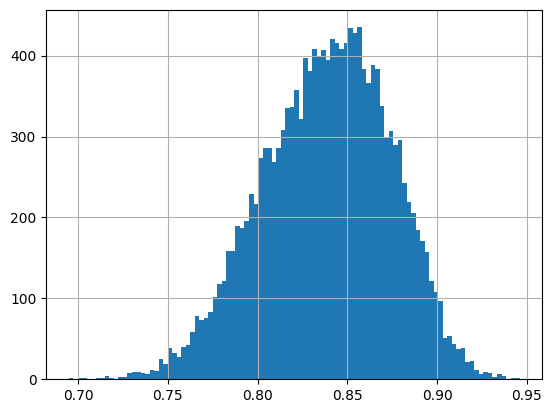

In [ ]:
df_schema['similarity'].hist(bins=100)

<Axes: >

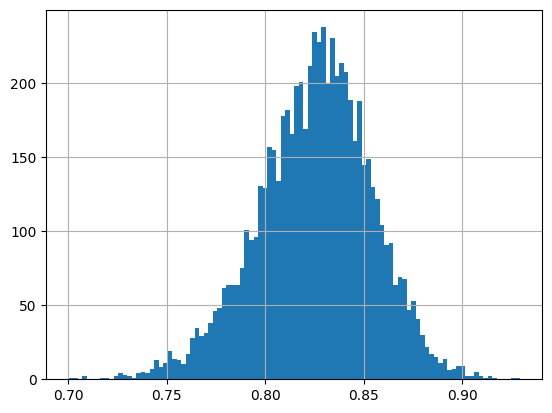

In [ ]:
df_counter['similarity'].hist(bins=100)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()